## Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sts

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

#To display all outputs in the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
#For LateX display
from IPython.display import display, Math


# Reflect Tables into SQLAlchemy ORM

In [2]:
#Create an engine to the hawaii.sqlite database
engine = create_engine("sqlite:///../Resources/hawaii.sqlite", echo=False) 

###############################################################
#ONLY FOR THE UOT EVALUATOR                                   #
#PLEASE NOTE THAT I CHANGED THE EXISTING DIRECTORY STRUCTURE  #
#A BIT TO MATCH MY USUAL GITHUB DIRECTORY STRUCTURE           #
#If you are using the one in gitlab, please use               #
#engine = create_engine("sqlite:///Resources/hawaii.sqlite")  #
###############################################################

#To view the sqlite table info
#engine.execute('SELECT * FROM sqlite_master').fetchall()
#'measurement' and 'station'

In [3]:
#Create an inspector and for engine (Not necessary, but, I prefer to view cleaner outputs for understanding metadata)
Inspector = inspect(engine)

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

#To display table info
#The below commands or the inspector
#Base.metadata.tables
#'measurement' and 'station'
#To display schema for a Class (mapped table)
#Base.classes.measurement.__dict__
#Base.classes.station.__dict__

#To display table info(A cleaner output using inspector)
[[f"Table name : {table}"]+[f"{col['name']} : {col['type']}{' (primary_key)' if col['primary_key']==1 else None}" \
                            for col in Inspector.get_columns(table)] for table in Inspector.get_table_names()]



[['Table name : measurement',
  'id : INTEGER (primary_key)',
  'station : TEXTNone',
  'date : TEXTNone',
  'prcp : FLOATNone',
  'tobs : FLOATNone'],
 ['Table name : station',
  'id : INTEGER (primary_key)',
  'station : TEXTNone',
  'name : TEXTNone',
  'latitude : FLOATNone',
  'longitude : FLOATNone',
  'elevation : FLOATNone']]

In [5]:
# We can view all of the classes that automap found
[Class.__dict__ for Class in Base.classes]

[mappingproxy({'__table__': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None),
               '__module__': 'sqlalchemy.ext.automap',
               '__doc__': None,
               '_sa_class_manager': <ClassManager of <class 'sqlalchemy.ext.automap.measurement'> at 118c0f8b0>,
               '__init__': <function __init__(self, **kwargs)>,
               'id': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x118c281d0>,
               'station': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x118c28270>,
               'date': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x118c28310>,
               'prcp': <sqlalchemy.orm.attributes.InstrumentedAttribute at 0x118c283b0>,
               'tobs': <sqlalc

In [6]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Climate Analysis

Text(0, 0.5, 'Precipitation (Inches)')

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


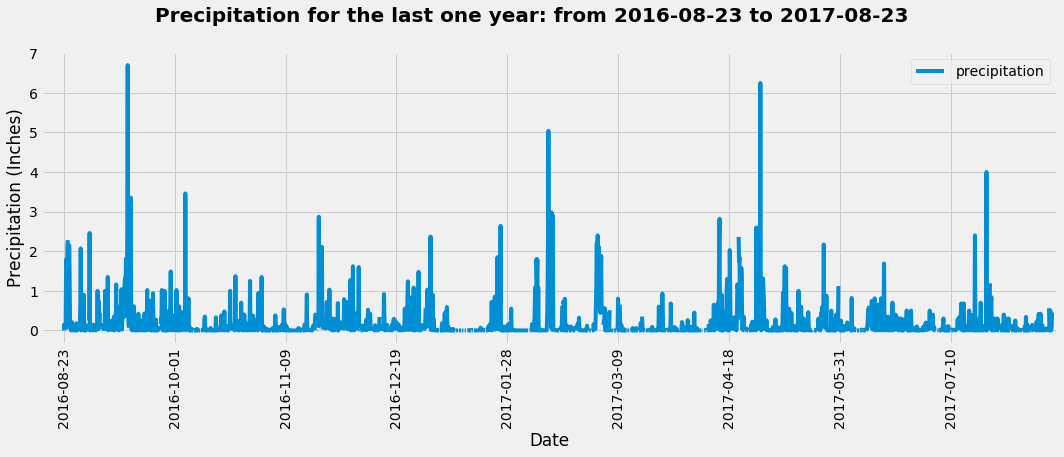

In [50]:
### Design a query to retrieve the last 12 months of precipitation data and plot the results


### Calculate the date 1 year ago from the last data point in the database
#start date:- '2010-01-01'
#last date:- '2017-08-23'
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).scalar()

### Last one year mark in the dataset
One_year_mark = dt.datetime.strptime(last_date, "%Y-%m-%d")-dt.timedelta(days=366)

### Perform a query to retrieve the data and precipitation scores
#sql alchemy understands the DateTime dtype and converts that to string implicitly!!
last_one_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(
    (Measurement.date >= One_year_mark)).order_by(Measurement.date).all()

### Save the query results as a Pandas DataFrame and set the index to the date column
last_one_year_prcp_DF = pd.DataFrame(last_one_year_prcp, columns=['Date','precipitation'])
last_one_year_prcp_DF.set_index('Date', inplace=True)
#There are 208 NUll prcp values

### Sort the dataframe by date (Though the data is sorted initially, creating DF from the data changes the order)
last_one_year_prcp_DF.sort_index(inplace=True)


### Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(15,6))
_=last_one_year_prcp_DF.plot(ax=ax)

### Annotation and labelling
xticks = np.arange(0,len(last_one_year_prcp_DF)+1,250)
xticklabels = last_one_year_prcp_DF.index[xticks].to_list()
plt.ylabel("Precipitation (Inches)")
_=plt.suptitle(f"Precipitation for the last one year: from {last_one_year_prcp_DF.index.min()} to {last_one_year_prcp_DF.index.max()}", fontsize=20, weight='bold', y=1.06)
_=plt.xlim((-50,len(last_one_year_prcp_DF)+10))
_=plt.xticks(xticks, xticklabels, rotation=90)
_=plt.tight_layout()
_= plt.savefig('../Images/Last_one_year_precipitation.png', bbox_inches = "tight" )

# Use Pandas to calcualte the summary statistics for the precipitation data
last_one_year_prcp_DF.describe()

# Station Analysis

In [32]:
# Design a query to show how many stations are available in this dataset?
#stations = session.query(func.distinct(Measurement.station)).all()
session.query(func.distinct(Measurement.station)).count()

9

In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
##pd.read_sql(session.query(Measurement.station, func.count(Measurement.station).label("Data Points(count)")).\
##group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).statement, session.bind)

result = session.query(Measurement.station, func.count(Measurement.station).label("Data Points(count)")).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

Station_Activity_DF = pd.DataFrame(result, columns=['station', 'Data Points(count)'])
Station_Activity_DF

#Which station has the highest number of observations?
#create a subquery
station_observation = session.query(Measurement.station.label("station"), func.count(Measurement.station).label("DataPoints")).\
group_by(Measurement.station).subquery()

most_active_station = session.query(station_observation.c.station).order_by(station_observation.c.DataPoints.desc()).limit(1).scalar()
most_active_station




,station,Data Points(count)
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


'USC00519281'

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


result = session.query(func.min(Measurement.tobs).label("lowest_temperature_recorded"),\
              func.max(Measurement.tobs).label("highest_temperature_recorded"),\
              func.avg(Measurement.tobs).label("average_temperature_recorded")).\
filter(Measurement.station==most_active_station).all()

pd.DataFrame(result, columns=["lowest_temperature_recorded", "highest_temperature_recorded", "average_temperature_recorded"])\
.applymap(lambda x: "{:.2f}$^\circ$F".format(x))

,lowest_temperature_recorded,highest_temperature_recorded,average_temperature_recorded
0,54.00$^\circ$F,85.00$^\circ$F,71.66$^\circ$F


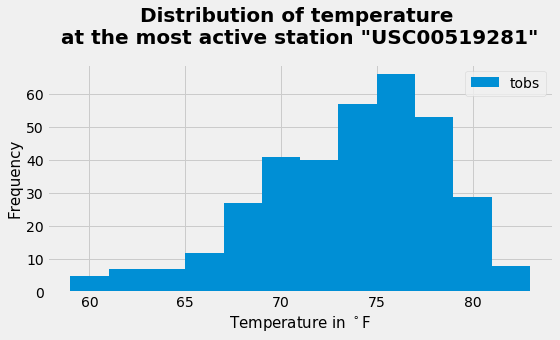

In [35]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Note:- most_temp_obs_station is same as the most_active_station only. This is for the sake of completion
most_temp_obs_station = session.query(Measurement.station, func.count(Measurement.tobs).label("Temperature Observations")).\
group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).limit(1).scalar()


##temp_obs_data_12_months_USC00519281 = pd.read_sql(session.query(Measurement.tobs).filter(\
##                                       (Measurement.date>=One_year_mark)&
##                                       (Measurement.station==most_temp_obs_station)).statement, session.bind)
##

result = session.query(Measurement.tobs).filter(\
                                  (Measurement.date>=One_year_mark)&\
                                  (Measurement.station==most_temp_obs_station)).all()

temp_obs_data_12_months_USC00519281 = pd.DataFrame(result, columns=['tobs'])
                     
fig, ax = plt.subplots(figsize=(8,5))
_=ax.hist(temp_obs_data_12_months_USC00519281['tobs'], label='tobs', bins=12)
_=plt.xlabel('Temperature in $^\circ$F', fontsize=15)
_=plt.ylabel('Frequency', fontsize=15)
_=plt.legend(loc='upper right')
_=plt.title(f"Distribution of temperature \nat the most active station \"{most_temp_obs_station}\"", fontsize=20, fontweight='bold', y=1.06)
_=plt.tight_layout()
_= plt.savefig('../Images/station-histogram_USC00519281.png', bbox_inches = "tight" )


## Bonus Challenge Assignment

## Temperature Analysis I

#### Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [36]:
#Extract june and december data
June_DF = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
             filter(func.strftime('%m', Measurement.date)=='06').order_by(Measurement.date).all(), columns=['Date', 'Temp'])

Dec_DF = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).\
             filter(func.strftime('%m', Measurement.date)=='12').order_by(Measurement.date).all(), columns=['Date', 'Temp'])

#Set Date as the index and sort by index for both the data frames
June_DF.set_index('Date', inplace=True)
Dec_DF.set_index('Date', inplace=True)
#Join both the DFs on index (outer join)
Combined_DF = June_DF.join(Dec_DF, how='outer', lsuffix='_June', rsuffix='_Dec')
#Sort index
Combined_DF.sort_index(inplace=True)
Combined_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3217 entries, 2010-06-01 to 2017-06-30
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Temp_June  1700 non-null   float64
 1   Temp_Dec   1517 non-null   float64
dtypes: float64(2)
memory usage: 75.4+ KB


**We don't have equal samples for june(1700 samples) and december(1517 samples). That itself shows that, we cannot do paired T-test**

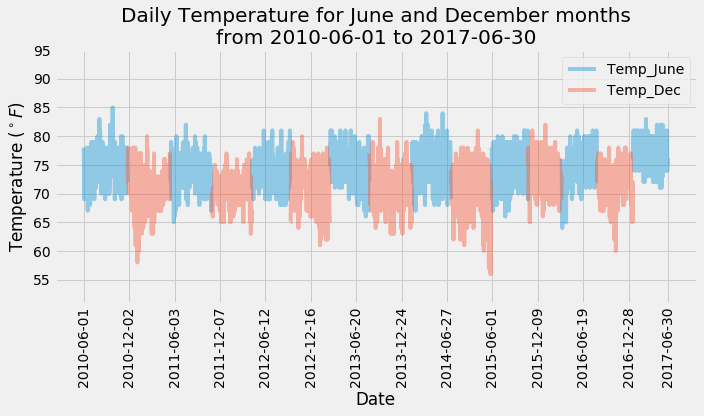

In [37]:
#Plot the time series graph
fig, ax = plt.subplots(figsize=(10,6))
_=Combined_DF.plot(ax=ax,alpha=0.4, legend=False)

xticks = list(np.arange(0,len(Combined_DF),250))+[len(Combined_DF)-1]
xticklabels = Combined_DF.index[xticks].to_list()
_=plt.ylim(Combined_DF.min().min()-5, Combined_DF.max().max()+10)
_=plt.xticks(xticks, xticklabels, rotation=90)
_=plt.legend(loc='upper right')
_=plt.ylabel("Temperature ($^\circ F$)")
_=plt.title(f"Daily Temperature for June and December months\nfrom {Combined_DF.index[0]} to {Combined_DF.index[-1]}", fontsize=20, y=1)
_=plt.tight_layout()
_= plt.savefig('../Images/temperature_june_dec_time_series.png', bbox_inches = "tight" )

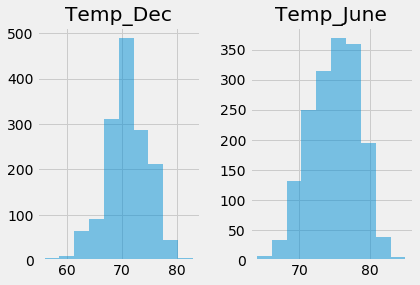

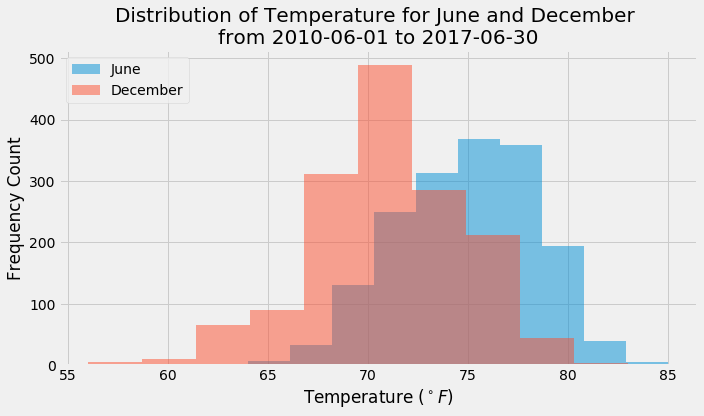

In [38]:
#Plot the histograms
_=Combined_DF.hist(column = ['Temp_June', 'Temp_Dec'], \
           alpha = 0.5)

fig, ax = plt.subplots(figsize=(10,6))
_=Combined_DF.hist(column = ['Temp_June'], \
           alpha = 0.5, ax=ax, label='June')
_=Combined_DF.hist(column = ['Temp_Dec'], \
           alpha = 0.5, ax=ax, label='December')
_=plt.xlabel("Temperature ($^\circ F$)")
_=plt.ylabel("Frequency Count")
_=plt.title(f"Distribution of Temperature for June and December \nfrom {Combined_DF.index[0]} to {Combined_DF.index[-1]}", fontsize=20, y=1)
_=plt.legend(loc='upper left')
_=plt.tight_layout()
_= plt.savefig('../Images/temperature_june_dec_histogram.png', bbox_inches = "tight" )

**The time series and histogram plots suggest that June seems to have higher temperature compared to December**

#### Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [39]:
#Remove NANs
JUNE=Combined_DF['Temp_June'][Combined_DF['Temp_June'].notna()]
DEC=Combined_DF['Temp_Dec'][Combined_DF['Temp_Dec'].notna()]
display(Math(r'\ Average\ temperature\ in\ June\ at\ all\ stations\ across\ all\ available\ year\ is\ :{}^\circ F\\\
Average\ temperature\ in\ December\ at\ all\ stations\ across\ all\ available\ year\ is\ :{}^\circ F'.format(np.round(np.mean(JUNE), 2), np.round(np.mean(DEC), 2))))

<IPython.core.display.Math object>

#### Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

* **We need to use unpaired(independent) T-test**
    * **Reason**
        - The paired t-test and the 1-sample t-test are actually the same test in disguise! A 1-sample t-test compares one sample mean to a null hypothesis value. A paired t-test simply calculates the difference between paired observations (e.g., before and after) and then performs a 1-sample t-test on the differences.
       - In our case, we have unequal sample size for June and December months because of the difference in the number of days of each month, samples not available for all stations for all days etc. We have 1700 samples for June and 1517 samples for June, and we cannot pair them in a before-after sense.
   
* **Further, we need to perform independent T-test with unequal variance**
    * **Reason**
        - Welch's t-test performs better than Student's t-test (equal variance) whenever sample sizes and variances are unequal between groups, and gives the same result when sample sizes and variances are equal. 
        - Refer https://www.rips-irsp.com/articles/10.5334/irsp.82/
    

In [40]:
sts.ttest_ind(JUNE, DEC, equal_var=False)

Ttest_indResult(statistic=31.35503692096242, pvalue=4.193529835915755e-187)

- **As p-value is < 0.05, we REJECT the null hypothesis (which states both the means are same)**
- **The mean temperature in June is statistically different (higher) than that of December**

**THE BELOW SECTION CAN BE IGNORED: IT IS JUST THE KNOWLEDGE BASE**

The selection of paired vs unpaired t-test is based on the **test subject**. If the subject is same, then we use ``paired t-test``, else ``unpaired t-test``.
  An example, taken from [socratic.org](https://socratic.org/questions/what-is-a-paired-and-unpaired-t-test-what-are-the-differences)
  
  If you wanted to conduct an experiment to see **how drinking an energy drink increases heart rate**, you could do it two ways.

  The "paired" way would be to measure the heart rate of 10 people before they drink the energy drink and then measure the heart rate of the same 10 people after     drinking the energy drink. These two samples consist of the same test subjects, so you would perform a paired t-test on the means of both samples.

  The "unpaired" way would be to measure the heart rate of 10 people before drinking an energy drink and then measure the heart rate of some other group of people   who have drank energy drinks. These two samples consist of different test subjects, so you would perform an unpaired t-test on the means of both samples.
  
  Now, let's look into the test statistic of both the tests;
  
  The paired t-test and the 1-sample t-test are actually the same test in disguise! A 1-sample t-test compares one sample mean to a null hypothesis value. 
  A paired t-test simply calculates the difference between paired observations (e.g., before and after) and then performs a 1-sample t-test on the differences.
  
  
**Paired t-test's test statistic**

<div align="center">
    <p align="center">
        <img src="../Images/paired_t_eqn.png" alt="paired_t_eqn"/>
    </p>                
</div>

**Unpaired/Independent t-test's test statistic (Equal or unequal sample sizes, similar population variances)**

<div align="center">
    <p align="center">
        <img src="../Images/Ind_t_eqn.png" alt="Ind_t_eqn"/>
    </p>                
</div>

**Welch's t-test : Unpaired/Independent t-test's test statistic (Equal or unequal sample sizes, unequal population variances)**

<div align="center">
    <p align="center">
        <img src="../Images/welch_t.png" alt="Ind_t_eqn"/>
    </p>                
</div>

## Temperature Analysis II

In [41]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year_start_date = '2017-04-01'
prev_year_end_date = '2017-04-10'
tmin, tavg, tmax = calc_temps(prev_year_start_date, prev_year_end_date)[0]

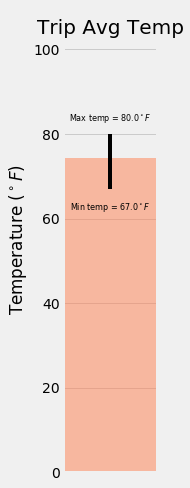

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=(2.5,7))
_=ax.bar([0], [tavg], width=0.5, color='coral', alpha=0.5)
_=plt.xlim((-0.25, 0.25))
_=plt.ylim((0, tmax+30))
_=plt.xticks([])
_=plt.ylabel("Temperature ($^\circ F$)")
_=plt.title(f"Trip Avg Temp", fontsize=20, y=0.93)

#Plot error bar. The right way to plot the error bar is as asymmetric with tmin at the bottom of the bar
#and tmax at the top of the bar.
_=plt.errorbar(x=0, y=tavg, yerr=[[tavg-tmin], [tmax-tavg]], zorder=2, c='k')


#Annotation
_=plt.annotate(f"Max temp = {tmax}$^\circ F$", (0, tmax+3), fontsize=8, ha='center')
_=plt.annotate(f"Min temp = {tmin}$^\circ F$", (0, tmin-5), fontsize=8, ha='center')

_=plt.tight_layout()
_= plt.savefig('../Images/temperature_err.png', bbox_inches = "tight" )

## Daily Rainfall Average
**NOTE: Though the heading says daily rainfall average, the description instructs to take the total. Discuss the same with the instructor and decided to go ahead with the total as per the description.**

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prev_year_start_date = '2017-04-01'
prev_year_end_date = '2017-04-10'

total_prcp_in_stations = session.query(Measurement.station,  func.sum(Measurement.prcp).label('Total_prcp')).\
filter(\
       (Measurement.date<=prev_year_end_date) &\
      (Measurement.date>=prev_year_start_date)).\
group_by(Measurement.station).order_by(func.avg(Measurement.prcp).desc()).subquery()


#Note that isouter=True makes the join as left join
#The isouter=True flag will produce a LEFT OUTER JOIN which is the same as a LEFT JOIN
#Ref: https://stackoverflow.com/questions/39619353/how-to-perform-a-left-join-in-sqlalchemy
result = session.query(total_prcp_in_stations.c.station, Station.name, Station.latitude, Station.longitude, Station.elevation, total_prcp_in_stations.c.Total_prcp).\
join(Station, Station.station == total_prcp_in_stations.c.station, isouter=True).all()

#Display
pd.DataFrame(result, columns=['station', 'name', 'latitude', 'longitude', 'elevation', 'Total_prcp'])


,station,name,latitude,longitude,elevation,Total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.90
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.73
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.16
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.17
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.00
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.00


In [45]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [46]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

normals = []
delta = dt.datetime.strptime(prev_year_end_date, "%Y-%m-%d") - dt.datetime.strptime(prev_year_start_date, "%Y-%m-%d")
dates = []
for i in range(delta.days+1):
    date = dt.datetime.strptime(prev_year_start_date, "%Y-%m-%d") + dt.timedelta(days=i)
    dates.append(dt.datetime.strftime(date, "%Y-%m-%d"))
    tmin,tavg,tmax = np.ravel(daily_normals(dt.datetime.strftime(date, "%m-%d")))
    normals.append((tmin,tavg,tmax))



In [47]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_DF = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'], index=dates)

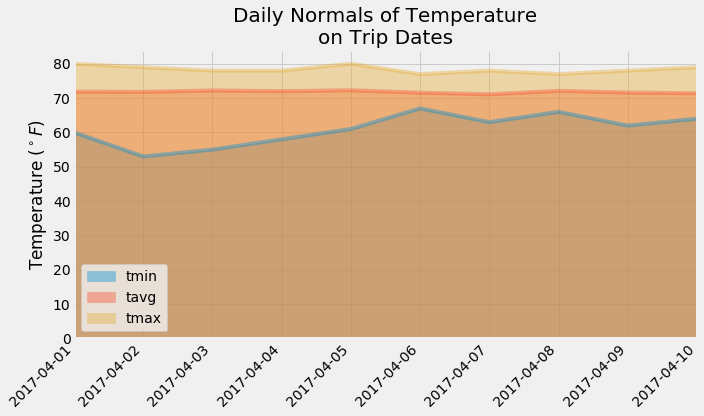

In [48]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize=(10,6))
_=normals_DF.plot.area(ax=ax, stacked=False, alpha=0.4)
_=plt.xticks(range(len(dates)), dates, rotation=45, ha='right')
_=plt.xlim((0,len(dates)-1))
_=plt.ylabel("Temperature ($^\circ F$)")
_=plt.title(f"Daily Normals of Temperature\non Trip Dates", fontsize=20, y=1)
_=plt.tight_layout()
_= plt.savefig('../Images/temperature_historical.png', bbox_inches = "tight" )